# Areal source models for Nath & Thingbaijam (2012)

Investigate and visualize models.

Note: For imports to work, ../utilities directory must be added to PYTHONPATH

_Copyright (C) 2015-2018 Nick Ackerley_

_This program is free software: you can redistribute it and/or modify
it under the terms of the GNU Affero General Public License as
published by the Free Software Foundation, either version 3 of the
License, or (at your option) any later version._

_This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the
GNU Affero General Public License for more details._

_You should have received a copy of the GNU Affero General Public 
License along with this program. If not, see 
<https://www.gnu.org/licenses/>._

In [1]:
import os
from time import time
from collections import OrderedDict

from IPython.display import display
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import geopandas as gpd

from shapely.geometry import Point
from obspy import UTCDateTime
from obspy.imaging.beachball import MomentTensor, mt2plane, aux_plane
from obspy.imaging.mopad_wrapper import beachball

from source_model_tools import csv2areal
from toolbox import wrap

pd.set_option('mode.chained_assignment', 'raise')

%matplotlib inline

In [2]:
MIN_MAGS = [4.5, 5.5]
LAYERS_DF = pd.read_csv('layers.csv', index_col='layerid')

# auxiliary information for comparison to model
AUX2_FILE = 'TRT_assignments_KKST.csv'
SIGNIFICANT_EVENTS_FILE = '../Data/nath2011peak/Table6.csv'
COMPLETENESS_FILE = '../Data/thingbaijam2011seismogenic/Table1.csv'
CATALOGUE_FILE = '../Catalogue/SACAT1900_2008v2.txt'
GCMT_FILE = '../Catalogue/jan76_dec17.ndk'

## Load areal zone description

In [3]:
areal_csv = 'nt2012_areal_source_model_v1.csv'
areal_df = csv2areal(areal_csv)

Reading: /home/nick/src/indian-subcontinent-psha/Source Models/nt2012_areal_source_model_v1.csv


## Query a zone

In [4]:
print('\nA typical zone:')
print(areal_df.loc[172])


A typical zone:
layerid                                                                 4
a                                                                    3.72
b                                                                    0.86
stdb                                                                  0.1
mmax                                                                    8
stdmmax                                                               0.3
strike                                                                 99
dip                                                                    64
rake                                                                  -50
geometry                POLYGON ((94.34999999999999 1.99, 90.010000000...
aspect ratio                                                            2
msr                                                     StrasserIntraslab
tectonic zone                                        Subduction intraslab
region               

## Compare with information provided by Kiran Thingbaijam

In [5]:
print('\nReading: ' + os.path.abspath(AUX2_FILE))
aux2_df = pd.read_csv(AUX2_FILE, na_values=['nan'], keep_default_na=False)
aux2_df.set_index('zoneid', inplace=True, verify_integrity=True)
aux2_df.sort_index(inplace=True)
assert (areal_df.index == aux2_df.index).all()
assert (areal_df['layerid'] == aux2_df['layerid']).all()

areal2_df = areal_df.join(aux2_df, rsuffix='2', how='outer')
areal2_df.fillna('', inplace=True)

print('\nThese zones have identical focal mechanisms:')
duplicated_df = areal2_df[
    areal2_df.duplicated(['strike', 'dip', 'rake'], keep=False) &
    np.logical_not(pd.isnull(areal2_df['dip'])) &
    (areal2_df['mechanism'] != 'undefined')].copy()
duplicated_df.sort_values('dip', inplace=True)
display(duplicated_df[
    ['layerid', 'faulting style', 'new style',
     'strike', 'dip', 'rake', 'mechanism',
     'strike2', 'dip2', 'rake2', 'mechanism2']
])


Reading: /home/nick/src/indian-subcontinent-psha/Source Models/TRT_assignments_KKST.csv

These zones have identical focal mechanisms:


,layerid,faulting style,new style,strike,dip,rake,mechanism,strike2,dip2,rake2,mechanism2
zoneid,,,,,,,,,,,
921,1,reverse,reverse,283,26,129,reverse,61.0,70.1,72.9,reverse
933,2,reverse,reverse,283,26,129,reverse,61.0,70.1,72.9,reverse
925,2,normal,normal,65,37,-26,sinistral,176.3,74.7,-124.1,normal
927,2,normal,normal,65,37,-26,sinistral,176.3,74.7,-124.1,normal
119,2,reverse,reverse,112,40,90,reverse,292.0,50.0,90.0,reverse
912,1,reverse,reverse,112,40,90,reverse,292.0,50.0,90.0,reverse
914,1,strike-slip,reverse,192,46,124,reverse,327.8,53.4,59.9,reverse
916,1,reverse,reverse,192,46,124,reverse,327.8,53.4,59.9,reverse
93,2,strike-slip,strike-slip,196,77,-2,sinistral,286.5,88.1,-167.0,sinistral


In [6]:
# bring terminologies in line for comparison

areal2_df['tectonic subregion'] = (
    areal2_df['tectonic subregion']
    .str.lower()
    .str.replace('himalayas', '')
    .str.replace('strike-slip reverse', '')
    .str.replace('normal', '')
    .str.strip()
)
areal2_df['tectonic zone'] = (
    areal2_df['tectonic zone']
    .str.lower()
)
areal2_df['mechanism'] = (
    areal2_df['mechanism']
    .replace('dextral', 'strike-slip')
    .replace('sinistral', 'strike-slip')
)
areal2_df['mechanism2'] = (
    areal2_df['mechanism2']
    .replace('dextral', 'strike-slip')
    .replace('sinistral', 'strike-slip')
)

different_mechanism_df = areal2_df[
    (areal2_df['mechanism'] != areal2_df['faulting style']) &
    (areal2_df['tectonic subregion'] != 'no seismicity') &
    (areal2_df['dip'].apply(np.isreal))
]
different_trt_df = areal2_df[
    (areal2_df['tectonic subregion'] !=
     areal2_df['tectonic region type']) &
    (areal2_df['tectonic subregion'] != 'no seismicity')
]

print('%d/%d (%d%%) mechanisms different' %
      (len(different_mechanism_df), len(areal_df),
       100*len(different_mechanism_df)/len(areal_df)))
print('%d/%d (%d%%) TRTs different' %
      (len(different_trt_df), len(areal_df),
       100*len(different_trt_df)/len(areal_df)))

12/104 (11%) mechanisms different
35/104 (33%) TRTs different


## Plot focal plane alternatives

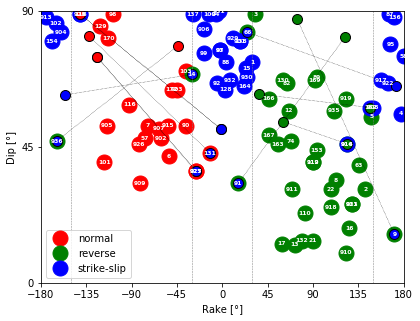

In [7]:
subset_df = areal2_df[
    areal2_df['dip'].apply(np.isreal) &
    (areal2_df['dip'] != -1) &
    (areal2_df['faulting style'] != '')]
wrong_df = different_mechanism_df[
    different_mechanism_df['dip'].apply(np.isreal) &
    (different_mechanism_df['dip'] != -1) &
    (different_mechanism_df['faulting style'] != '')]
colours = {
    'normal': 'red',
    'reverse': 'green',
    'strike-slip': 'blue'
}

fig, ax = plt.subplots(figsize=(6.5, 5))
ax.margins(0.05)  # Optional, just adds 5% padding to the autoscaling

for name, group in subset_df.groupby('faulting style'):
    ax.plot(group['rake'], group['dip'], color=colours[name],
            marker='o', markersize=15, linestyle='', linewidth=2,
            label=name)
    for x, y, zone_id in zip(group['rake'], group['dip'], group.index):
        ax.annotate(s=zone_id, xy=(x, y),
                    xytext=(0, 0), textcoords='offset points',
                    fontsize=6, fontweight='bold', color='white',
                    horizontalalignment='center',
                    verticalalignment='center')
for _, zone in wrong_df.iterrows():
    ax.plot([zone['rake'], zone['rake2']], [zone['dip'], zone['dip2']],
            linestyle=':', color='black', linewidth=0.5, label=None)
    ax.plot(zone['rake'], zone['dip'], color=colours[zone['mechanism']],
            marker='o', markersize=10, markeredgecolor='black',
            linestyle='', linewidth=2, label=None)
    ax.plot(zone['rake2'], zone['dip2'], color=colours[zone['mechanism2']],
            marker='o', markersize=10, markeredgecolor='black',
            linestyle='', linewidth=2, label=None)

ax.legend(loc='lower left')
for threshhold in [-150, -30, 30, 150]:
    ax.axvline(x=threshhold, linestyle='--', color='grey', linewidth=0.5)
ax.set_xlim((-180, 180))
ax.set_xlabel(('Rake [°]'))
ax.set_xticks(range(-180, 181, 45))
ax.set_ylim((0, 90))
ax.set_ylabel(('Dip [°]'))
ax.set_yticks(range(0, 91, 45))

fig.savefig('FocalMechanisms.png', transparent=True, dpi=300,
            bbox_inches='tight', pad_inches=0.1)

## Summarize discrepancies

In [8]:
print('\nZoes with wrong faulting style in the initial implementation')
display(wrong_df[
    ['layerid', 'faulting style', 'new style',
     'strike', 'dip', 'rake', 'mechanism',
     'strike2', 'dip2', 'rake2', 'mechanism2']])


print('\nZones with different tectonic region types')
display(different_trt_df[[
    'layerid', 'strike', 'dip', 'rake', 'a',
    'mechanism', 'faulting style',
    'tectonic zone', 'tectonic subregion', 'tectonic region type'
]])

print('\nZones with different faulting styles')
display(different_mechanism_df[[
    'layerid', 'strike', 'dip', 'rake',
    'mechanism', 'faulting style',
]])

print('\nZones assigned different faulting styles')

keep_columns = ['layerid', 'strike', 'dip', 'rake',
                'mechanism', 'mechanism2', 'faulting style', 'new style']
display(different_mechanism_df[
    different_mechanism_df['faulting style'] !=
    different_mechanism_df['new style']][keep_columns])

print('\nNon-zero b-values:')
print(areal_df[areal_df['stdb'] != 0]['stdb'].describe())

print('\nHighest and lowest activity rates')
drop_columns = ['tectonic zone', 'region', 'geometry',
                'aspect ratio', 'dip', 'rake', 'strike']
temp_df = areal_df[areal_df.a != 0].drop(drop_columns, axis=1).sort_values('a')
display(pd.concat([temp_df.head(), temp_df.tail()]))

print('\nZones without seismicity:')
areal_df[areal_df['tectonic subregion'] == 'no seismicity'].drop(
    drop_columns, axis=1)

print('\nTectonic subregions:', set(areal_df['tectonic subregion']))


Zoes with wrong faulting style in the initial implementation


,layerid,faulting style,new style,strike,dip,rake,mechanism,strike2,dip2,rake2,mechanism2
zoneid,,,,,,,,,,,
9,1,reverse,reverse,36,16,171,strike-slip,134.7,87.5,74.2,reverse
14,1,reverse,strike-slip,228,69,-30,strike-slip,329.7,62.2,-156.1,strike-slip
66,1,reverse,strike-slip,58,83,25,strike-slip,324.7,65.2,172.3,strike-slip
91,2,reverse,reverse,63,33,16,strike-slip,319.5,81.4,122.0,reverse
118,2,strike-slip,normal,301,89,-141,normal,210.2,51.0,-1.3,strike-slip
131,2,normal,normal,256,43,-12,strike-slip,354.8,81.8,-132.4,normal
162,3,strike-slip,reverse,176,58,147,reverse,285.0,62.5,36.7,reverse
914,1,strike-slip,reverse,192,46,124,reverse,327.8,53.4,59.9,reverse
925,2,normal,normal,65,37,-26,strike-slip,176.3,74.7,-124.1,normal



Zones with different tectonic region types


,layerid,strike,dip,rake,a,mechanism,faulting style,tectonic zone,tectonic subregion,tectonic region type
zoneid,,,,,,,,,,
13,1,299.4,12.6,71.8,3.24,reverse,reverse,subduction interface,subduction interface,active shallow crust
87,2,150,89,166,5.97,strike-slip,strike-slip,subduction interface,subduction interface,
88,2,210,73,4,6.07,strike-slip,strike-slip,subduction interface,subduction interface,
90,2,210,52,-36,5.80,normal,normal,subduction interface,subduction interface,subduction intraslab
91,2,63,33,16,4.72,strike-slip,reverse,subduction interface,subduction interface,
92,2,194,66,-5,4.80,strike-slip,strike-slip,subduction interface,subduction interface,
93,2,196,77,-2,5.66,strike-slip,strike-slip,subduction interface,subduction interface,
94,2,11,89,-6,4.51,strike-slip,strike-slip,subduction interface,subduction interface,
95,2,23,79,167,4.35,strike-slip,strike-slip,subduction interface,subduction interface,



Zones with different faulting styles


,layerid,strike,dip,rake,mechanism,faulting style
zoneid,,,,,,
9,1,36,16,171,strike-slip,reverse
14,1,228,69,-30,strike-slip,reverse
66,1,58,83,25,strike-slip,reverse
91,2,63,33,16,strike-slip,reverse
118,2,301,89,-141,normal,strike-slip
131,2,256,43,-12,strike-slip,normal
162,3,176,58,147,reverse,strike-slip
914,1,192,46,124,reverse,strike-slip
925,2,65,37,-26,strike-slip,normal



Zones assigned different faulting styles


,layerid,strike,dip,rake,mechanism,mechanism2,faulting style,new style
zoneid,,,,,,,,
14,1,228,69,-30,strike-slip,strike-slip,reverse,strike-slip
66,1,58,83,25,strike-slip,strike-slip,reverse,strike-slip
118,2,301,89,-141,normal,strike-slip,strike-slip,normal
162,3,176,58,147,reverse,reverse,strike-slip,reverse
914,1,192,46,124,reverse,reverse,strike-slip,reverse
928,2,301,89,-141,normal,strike-slip,strike-slip,normal
936,3,140,47,-164,strike-slip,normal,reverse,normal



Non-zero b-values:
count    99.000000
mean      0.095354
std       0.024839
min       0.030000
25%       0.080000
50%       0.100000
75%       0.115000
max       0.160000
Name: stdb, dtype: float64

Highest and lowest activity rates


,layerid,a,b,stdb,mmax,stdmmax,msr,tectonic subregion,focal plane,faulting style,...,mechanism,new style,strike2,dip2,rake2,mechanism2,mmin,centroid,source_name,id
zoneid,,,,,,,,,,,,,,,,,,,,,
924,1,1.58,0.63,0.10,6.2,0.3,WC1994,stable shallow crust,primary,strike-slip,...,undefined,undefined,270.0,90.0,89.0,reverse,4.5,POINT (83.90 19.63),zone 924,z924
923,1,2.51,0.73,0.06,6.0,0.3,WC1994,stable shallow crust,primary,strike-slip,...,undefined,undefined,270.0,90.0,89.0,reverse,4.5,POINT (76.67 12.77),zone 923,z923
921,1,2.53,0.76,0.07,7.0,0.4,WC1994,stable shallow crust,primary,reverse,...,reverse,reverse,61.0,70.1,72.9,reverse,4.5,POINT (79.77 22.50),zone 921,z921
74,1,2.57,0.86,0.07,6.5,0.3,WC1994,stable shallow crust,primary,reverse,...,reverse,reverse,134.6,47.3,111.9,reverse,4.5,POINT (76.54 18.37),zone 74,z74
81,1,2.65,0.86,0.12,6.2,0.3,WC1994,stable shallow crust,primary,strike-slip,...,undefined,undefined,270.0,90.0,89.0,reverse,4.5,POINT (80.47 15.48),zone 81,z81
116,2,6.23,1.30,0.12,7.0,0.2,StrasserInterface,subduction interface,primary,normal,...,normal,normal,30.9,31.1,-86.7,normal,4.5,POINT (94.72 31.85),zone 116,z116
154,3,6.37,1.28,0.09,7.3,0.3,StrasserIntraslab,subduction intraslab Himalayas,primary,strike-slip,...,sinistral,strike-slip,8.1,79.2,-10.2,sinistral,4.5,POINT (74.09 38.23),zone 154,z154
57,1,6.79,1.35,0.10,7.2,0.4,WC1994,active shallow crust normal,primary,normal,...,normal,normal,45.0,43.6,-104.0,normal,4.5,POINT (95.16 11.67),zone 57,z57
909,1,7.08,1.37,0.12,7.6,0.3,WC1994,active shallow crust normal,primary,normal,...,normal,normal,78.5,57.4,-95.2,normal,4.5,POINT (92.94 32.23),zone 909,z909



Zones without seismicity:

Tectonic subregions: {'active shallow crust normal', 'intraplate margin upper', 'subduction intraslab Himalayas', 'subduction intraslab', 'stable shallow crust', 'intraplate margin lower', 'no seismicity', 'subduction interface ', 'subduction interface', 'active shallow crust strike-slip reverse'}


## Histograms of FMD parameters

/home/nick/anaconda3/envs/oq/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return reshape(newshape, order=order)


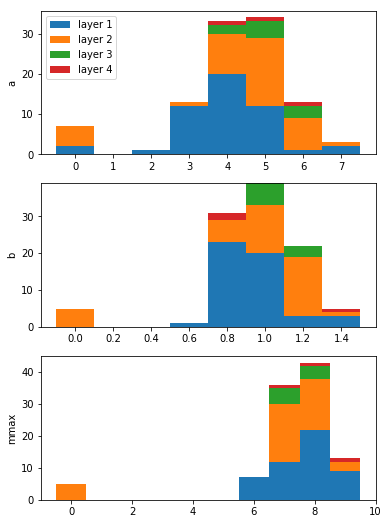

In [9]:
props = ['a', 'b', 'mmax']
ranges = [np.arange(-0.5, 8, 1),
          np.arange(-0.1, 1.7, 0.2),
          np.arange(-0.5, 10, 1)]
groups = areal_df.groupby('layerid')
fig, axes = plt.subplots(nrows=len(props), ncols=1,
                         figsize=(6, 3*len(props)))
for prop, ax, bins in zip(props, axes, ranges):
    data = [group[prop] for _, group in groups]
    labels = ['layer %d' % layer_id for layer_id, _ in groups]
    ax.hist(data, label=labels, stacked=True, bins=bins)
    ax.set_ylabel(prop)
axes[0].legend(loc='upper left')

## Associate catalogue events wtih zones


Reading catalogue: /home/nick/src/indian-subcontinent-psha/Catalogue/SACAT1900_2008v2.txt


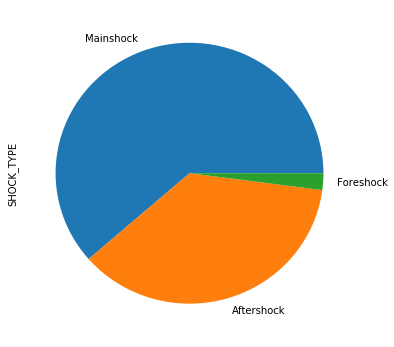

In [10]:
print('\nReading catalogue: ' + os.path.abspath(CATALOGUE_FILE))
catalogue_df = pd.read_csv(CATALOGUE_FILE, sep='\t')

fig, ax = plt.subplots(figsize=(6, 6))
catalogue_df['SHOCK_TYPE'].value_counts().plot(kind='pie', ax=ax)

In [11]:
mark = time()
catalogue_df['geometry'] = [Point(lon, lat)
                            for lon, lat in zip(catalogue_df['LON'],
                                                catalogue_df['LAT'])]
layer_catalogue_gdfs = []
for layer_id, layer in LAYERS_DF.iterrows():
    layer_catalogue_gdf = gpd.GeoDataFrame(catalogue_df[
        (catalogue_df['DEPTH'] >= layer['zmin']) &
        (catalogue_df['DEPTH'] < layer['zmax'])], crs='WGS84')
    layer_areal_gdf = gpd.GeoDataFrame(
        areal_df[areal_df['layerid'] == layer_id].reset_index()
        [['geometry', 'zoneid', 'layerid']], crs='WGS84')
    layer_catalogue_gdfs.append(
        gpd.sjoin(layer_catalogue_gdf, layer_areal_gdf,
                  how='left', op='intersects'))
catalogue_df = pd.concat(layer_catalogue_gdfs).drop('geometry')
print('Associated %d events with %d zones (%.0f s)' %
      (len(catalogue_df), len(areal_df), time() - mark))
display(pd.concat((catalogue_df.head(), catalogue_df.tail())))

Associated 49403 events with 104 zones (4 s)


,YEAR,MONTH,DAY,HH,MM,SS,LAT,LON,DEPTH,DEPTH_ERR,...,MAG,MAG_ERR,MAG_MW,MAG_MW_ERR,SOURCE,SHOCK_TYPE,geometry,index_right,zoneid,layerid
39,1906,10,4,6,52,-1.00,37.2000,67.3000,20.0,-1.0,...,5.70,-1.0,5.8,-1.00,AB2003a,Mainshock,POINT (67.3 37.2),NaN,NaN,NaN
46,1907,10,21,4,23,36.00,38.7000,68.1000,24.0,-1.0,...,7.30,-1.0,7.2,-1.00,UL2006a,Mainshock,POINT (68.09999999999999 38.7),NaN,NaN,NaN
48,1907,10,24,5,10,-1.00,38.0000,68.8000,18.0,-1.0,...,5.20,-1.0,5.5,-1.00,AB2003a,Mainshock,POINT (68.8 38),0.0,1.0,1.0
74,1911,1,1,14,59,0.00,36.5000,66.0000,20.0,-1.0,...,6.47,-1.0,6.4,-1.00,AB2003a,Mainshock,POINT (66 36.5),NaN,NaN,NaN
96,1913,9,9,18,43,-1.00,37.1000,68.1000,18.0,-1.0,...,5.00,-1.0,5.4,-1.00,AB2003a,Mainshock,POINT (68.09999999999999 37.1),4.0,5.0,1.0
50295,2008,12,26,15,56,29.97,37.1880,72.0040,216.8,41.0,...,3.20,0.1,3.4,0.28,ISC,Mainshock,POINT (72.00399999999999 37.188),1.0,170.0,4.0
50297,2008,12,26,22,12,56.66,36.2475,70.3301,189.1,66.0,...,3.20,0.2,3.4,0.33,ISC,Mainshock,POINT (70.3301 36.2475),0.0,169.0,4.0
50317,2008,12,29,18,24,32.58,36.4481,71.0448,200.0,46.0,...,3.30,0.1,3.5,0.28,ISC,Aftershock,POINT (71.0448 36.4481),0.0,169.0,4.0
50319,2008,12,30,3,9,28.10,36.4556,70.9448,198.7,29.0,...,3.90,-1.0,4.6,0.19,ISC,Aftershock,POINT (70.9448 36.4556),0.0,169.0,4.0
50331,2008,12,31,20,48,35.71,36.2467,70.8264,197.0,44.0,...,3.30,0.1,3.5,0.28,ISC,Mainshock,POINT (70.82640000000001 36.2467),0.0,169.0,4.0


## Completeness tables

In [12]:
print('\nReading completeness: ' + os.path.abspath(COMPLETENESS_FILE))
completeness_df = pd.read_csv(COMPLETENESS_FILE,
                              header=[0, 1], index_col=[0, 1])
# completeness_df.reset_index(inplace=True)
completeness_df.columns = [' '.join(col).strip()
                           for col in completeness_df.columns.values]
display(completeness_df)


Reading completeness: /home/nick/src/indian-subcontinent-psha/Data/thingbaijam2011seismogenic/Table1.csv


,,4 start,4 end,4.5 start,4.5 end,5.5 start,5.5 end
zmin,zmax,,,,,,
0,25,1994,2008,1964,2008,1903,2008
25,70,1990,2008,1964,2008,1902,2008
70,180,1996,2008,1964,2008,1914,2008
180,300,1984,2008,1970,2008,1912,2008


## Compute areal zone activity rates from catalogue

In [13]:
catalogue_activity_df = pd.DataFrame()
for layer_id, layer in LAYERS_DF.join(completeness_df,
                                      on=['zmin', 'zmax']).iterrows():
    layer_results = pd.Series()
    for mag in reversed(MIN_MAGS):
        above_thresh = catalogue_df['MAG_MW'] >= mag
        start = layer[str(mag) + ' start']
        end = layer[str(mag) + ' end']
        at_depth = ((catalogue_df['DEPTH'] >= layer['zmin']) &
                    (catalogue_df['DEPTH'] < layer['zmax']))
        in_years = ((catalogue_df['YEAR'] >= start) &
                    (catalogue_df['YEAR'] <= end))
        in_a_zone = catalogue_df['zoneid'] != -1
        is_mainshock = catalogue_df['SHOCK_TYPE'] == 'Mainshock'
        subcat_df = catalogue_df[
            above_thresh & at_depth & in_years & in_a_zone & is_mainshock]
        layer_results = layer_results.append(pd.Series({
            'catalogue ' + str(mag):
                round(float(len(subcat_df))/(end - start + 1), 1),
            }, name=layer_id))
    catalogue_activity_df = catalogue_activity_df.append(layer_results,
                                                         ignore_index=True)
catalogue_activity_df = catalogue_activity_df.append(pd.Series(
    catalogue_activity_df.sum(axis=0), name='Total'))
display(catalogue_activity_df)

,catalogue 4.5,catalogue 5.5
0,87.9,5.1
1,98.1,4.9
2,44.3,1.8
3,11.6,1.3
Total,241.9,13.1


# Compute average moment tensors and focal mechanisms from GCMT Catalogue

Note that in obpsy.beachball "M11, M22, M33, M12, M13, M23 - the six independent components of the moment tensor, where the coordinate system is 1,2,3 = Up,South,East which equals r,theta,phi - Harvard/Global CMT convention":
https://docs.obspy.org/packages/autogen/obspy.imaging.beachball.beach.html#obspy.imaging.beachball.beach

In [14]:
from obspy import read_events
gcmt_catalog = read_events(GCMT_FILE)

/home/nick/anaconda3/envs/oq/lib/python3.5/site-packages/obspy/io/ndk/core.py:205: ObsPyNDKWarning: Could not parse event 13965 (faulty file?). Will be skipped. Lines of the event:
	PDE  1996/11/20 19:42:56.1  10.30  127.43  33.0 5.6 5.3 PHILIPPINE ISLANDS REGIO
	B112096E         B: 35   58  45 S:  0    0   0 M:  0    0   0 CMT: 1 BOXHD: 22.0
	CENTROID:      1.060.0  10.47 0.03  127.42 0.03  15.0  0.0 BDY  O-00000000000000
	24 -4.983 0.133 -0.092 0.153  5.075 0.173 -0.433 0.443  0.715 0.469 -2.898 0.141
	V10   6.430  4 246  -1.390  2 156  -5.050 86  45   5.740 338 41  -88 154 49  -92
Traceback (most recent call last):
  File "/home/nick/anaconda3/envs/oq/lib/python3.5/site-packages/obspy/io/ndk/core.py", line 197, in _read_ndk
    record = _read_lines(*lines)
  File "/home/nick/anaconda3/envs/oq/lib/python3.5/site-packages/obspy/io/ndk/core.py", line 522, in _read_lines
    map(float, line3[:58].split()[1:])
ValueError: could not convert string to float: '1.060.0'

  warnings.warn(msg,

In [15]:
events = []
for event in gcmt_catalog:
    origin = event.preferred_origin()
    if not ((2 <= origin.latitude <= 40) & 
            (55 <= origin.longitude <= 101) &
            (origin.time < UTCDateTime(2009, 1, 1))):
        continue
    magnitude = event.preferred_magnitude()
    mechanism = event.preferred_focal_mechanism()
    np1 = mechanism.nodal_planes.nodal_plane_1
    np2 = mechanism.nodal_planes.nodal_plane_2
    moment_tensor = mechanism.moment_tensor
    events.append(pd.Series(OrderedDict((
        ('time', origin.time),
        ('longitude', origin.longitude),
        ('latitude', origin.latitude),
        ('depth', origin.depth*1e-3),
        ('magnitude', magnitude.mag),
        ('magnitude_type', magnitude.magnitude_type),
        ('strike1', np1.strike),
        ('dip1', np1.dip),
        ('rake1', np1.rake),
        ('strike2', np2.strike),
        ('dip2', np2.dip),
        ('rake2', np2.rake),
        ('scalar_moment', moment_tensor.scalar_moment),
        ('m_rr', moment_tensor.tensor.m_rr),
        ('m_tt', moment_tensor.tensor.m_tt),
        ('m_pp', moment_tensor.tensor.m_pp),
        ('m_rt', moment_tensor.tensor.m_rt),
        ('m_rp', moment_tensor.tensor.m_rp),
        ('m_tp', moment_tensor.tensor.m_tp),
    ))))
gcmt_df = pd.DataFrame(events)

In [16]:
gcmt_df['geometry'] = [Point(lon, lat)
                       for lon, lat in zip(gcmt_df['longitude'],
                                           gcmt_df['latitude'])]
layer_gcmt_gdfs = []
for layer_id, layer in LAYERS_DF.iterrows():
    layer_gcmt_gdf = gpd.GeoDataFrame(gcmt_df[
        (gcmt_df['depth'] >= layer['zmin']) &
        (gcmt_df['depth'] < layer['zmax'])], crs='WGS84')
    layer_areal_gdf = gpd.GeoDataFrame(
        areal_df[areal_df['layerid'] == layer_id].reset_index()
        [['geometry', 'zoneid', 'layerid']], crs='WGS84')
    layer_gcmt_gdfs.append(
        gpd.sjoin(layer_gcmt_gdf, layer_areal_gdf,
                  how='left', op='intersects'))
gcmt_gdf = pd.concat(layer_gcmt_gdfs).drop('geometry')
print('Associated %d/%d events with %d zones' %
      (len(gcmt_gdf[~pd.isnull(gcmt_gdf.zoneid)]), len(gcmt_df), len(areal_df)))
gcmt_gdf.tail()

Associated 1682/2134 events with 104 zones


,time,longitude,latitude,depth,magnitude,magnitude_type,strike1,dip1,rake1,strike2,...,m_rr,m_tt,m_pp,m_rt,m_rp,m_tp,geometry,index_right,zoneid,layerid
1992,2008-02-23T04:41:19.400000Z,70.69,36.45,194.3,4.87,Mwc,292.0,20.0,123.0,77.0,...,1.440000e+16,-1.500000e+16,5.900000e+14,1.990000e+16,6.240000e+15,1.620000e+15,POINT (70.69 36.45),0.0,169.0,4.0
2014,2008-05-11T20:57:09.800000Z,70.62,36.38,217.8,5.39,Mwc,282.0,22.0,103.0,88.0,...,1.100000e+17,-1.020000e+17,-8.300000e+15,1.100000e+17,9.500000e+15,9.800000e+15,POINT (70.62 36.38),0.0,169.0,4.0
2073,2008-09-05T04:57:53.200000Z,71.12,36.52,224.9,5.41,Mwc,205.0,26.0,72.0,44.0,...,1.240000e+17,-3.960000e+16,-8.400000e+16,8.100000e+16,6.720000e+16,-5.450000e+16,POINT (71.12 36.52),0.0,169.0,4.0
2074,2008-09-06T05:47:41.100000Z,70.78,36.49,183.0,5.83,Mwc,85.0,18.0,104.0,250.0,...,4.250000e+17,-3.840000e+17,-4.140000e+16,-5.300000e+17,-2.140000e+17,-7.580000e+16,POINT (70.78 36.49),0.0,169.0,4.0
2102,2008-10-26T01:28:58.200000Z,70.46,36.44,199.7,5.73,Mwc,273.0,18.0,87.0,97.0,...,2.820000e+17,-2.940000e+17,1.220000e+16,4.090000e+17,-4.960000e+16,2.760000e+16,POINT (70.45999999999999 36.44),0.0,169.0,4.0


In [17]:
zone_gcmts = []
for zoneid, zone_df in gcmt_gdf.groupby('zoneid'):
    zone = zone_df[['m_rr', 'm_tt', 'm_pp', 'm_rt', 'm_rp', 'm_tp']].apply(
        lambda item: np.average(item, weights=zone_df.scalar_moment))
    zone.name = int(zoneid)
    
    zone['scalar_moment'] = zone_df.scalar_moment.sum()
    nodal_plane = mt2plane(MomentTensor((zone.m_rr, zone.m_tt, zone.m_pp, 
                                         zone.m_rt, zone.m_rp, zone.m_tp), 
                                        zone.scalar_moment))
    zone['strike1'] = nodal_plane.strike
    zone['dip1'] = nodal_plane.dip
    zone['rake1'] = nodal_plane.rake
    zone['strike2'], zone['dip2'], zone['rake2']  = aux_plane(
        nodal_plane.strike, nodal_plane.dip, nodal_plane.rake)
    zone_gcmts.append(zone)
zone_gcmt_df = pd.DataFrame(zone_gcmts)
zone_gcmt_df.index.name = 'zoneid'

zone_gcmt_df[['strike1', 'dip1', 'rake1', 'strike2', 'dip2', 'rake2']] = \
    zone_gcmt_df[['strike1', 'dip1', 'rake1', 'strike2', 'dip2', 'rake2']].round(1)
    
zone_gcmt_df[['rake1', 'rake2']] = zone_gcmt_df[['rake1', 'rake2']].apply(wrap)

1


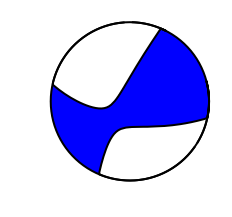

3


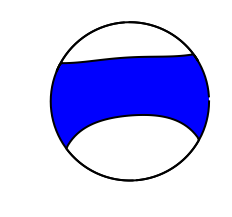

14


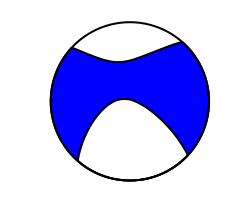

914


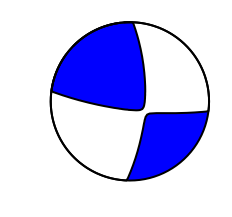

In [18]:
zoneids = [1, 3, 14, 914]
for zoneid in zoneids:
    zone = zone_gcmt_df.loc[zoneid]
    print(zoneid)
    beachball((zone.m_rr, zone.m_tt, zone.m_pp,  zone.m_rt, zone.m_rp, zone.m_tp))

In [19]:
zone_gcmt_df.loc[zoneids]

,m_rr,m_tt,m_pp,m_rt,m_rp,m_tp,scalar_moment,strike1,dip1,rake1,strike2,dip2,rake2
zoneid,,,,,,,,,,,,,
1,2.012014e+18,-4.121552e+18,2.109404e+18,-1.182065e+17,-2.925319e+18,-4.399419e+18,1.501137e+19,103.4,59.2,162.2,202.8,74.8,32.0
3,1.060478e+18,-1.788794e+18,7.280489e+17,1.107589e+18,9.298852e+16,-1.680067e+17,1.397618e+19,84.9,63.9,88.5,268.4,26.1,93.1
14,-5.447121e+16,-9.484860e+17,1.002957e+18,6.844852e+17,-1.445225e+17,-1.016522e+17,5.560000e+18,314.0,78.9,-150.8,217.8,61.4,-12.7
914,3.585603e+18,1.545987e+18,-5.131590e+18,8.410026e+18,3.615082e+18,2.007704e+19,4.656195e+19,97.3,77.3,22.6,2.1,68.0,166.3


In [20]:
areal_df.loc[zoneids]

,layerid,a,b,stdb,mmax,stdmmax,strike,dip,rake,geometry,...,mechanism,new style,strike2,dip2,rake2,mechanism2,mmin,centroid,source_name,id
zoneid,,,,,,,,,,,,,,,,,,,,,
1,1,5.20,1.05,0.07,8.0,0.4,202.0,73.0,30.0,"POLYGON ((67.81 37.55, 68.3 38.82, 72.95 39.99...",...,dextral,strike-slip,102.4,61.4,160.6,dextral,4.5,POINT (70.44 38.79),zone 1,z1
3,1,3.75,0.77,0.05,8.0,0.4,59.0,89.0,33.0,"POLYGON ((76.09999999999999 38.89, 76.53 39.99...",...,reverse,reverse,328.4,57.0,178.8,dextral,4.5,POINT (77.66 39.43),zone 3,z3
14,1,3.12,0.72,0.09,8.6,0.4,228.0,69.0,-30.0,"POLYGON ((60 27.11, 64.52 27.59, 66.66 25.14, ...",...,sinistral,strike-slip,329.7,62.2,-156.1,sinistral,4.5,POINT (62.68 25.50),zone 14,z14
914,1,5.24,1.01,0.09,8.3,0.4,192.0,46.0,124.0,"POLYGON ((94.45 13.23, 95 14.58, 95.66 16.28, ...",...,reverse,reverse,327.8,53.4,59.9,reverse,4.5,POINT (96.47 18.90),zone 914,z914


What is going on with the Makran zone? How is this not (in aggregate) a thrust mechanism?

ZONE 14
1979-01-10T01:26:09.400000Z 5.96 Mwc


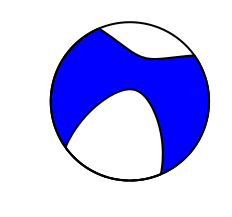

1979-01-10T15:05:50.200000Z 6.09 Mwc


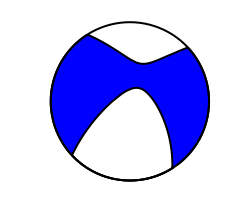

1990-06-17T04:51:44.800000Z 6.1 Mwc


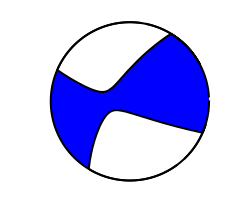

1991-12-07T14:22:39.200000Z 5.57 Mwc


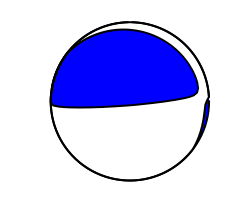

1992-01-30T05:22:02.700000Z 5.82 Mwc


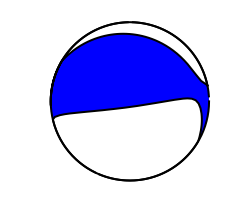

ZONE 13
1980-08-23T21:36:55.200000Z 5.51 Mwc


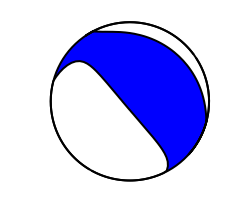

1980-08-23T21:50:05.700000Z 5.54 Mwc


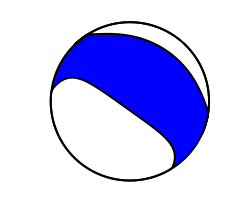

1986-04-26T07:35:20.000000Z 5.51 Mwc


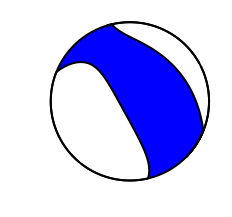

In [21]:
for zoneid in [14, 13]:
    print('ZONE', zoneid)
    for _, event in gcmt_gdf[gcmt_gdf.zoneid == zoneid].iterrows():
        print(str(event.time), str(event.magnitude), event.magnitude_type)
        beachball((event.m_rr, event.m_tt, event.m_pp,  event.m_rt, event.m_rp, event.m_tp))

So Makran has a bimodal distribution of focal mechanisms ...

# Generate SVG beachballs for display in QGIS

In [22]:
bb_dir = './beachballs/'
print('\nGenerating SVG beachballs for areal zones:\n\t' +
      os.path.abspath(bb_dir))

mark = time()

if not os.path.isdir(bb_dir):
    os.mkdir(bb_dir)

for zoneid, zone in areal_df.iterrows():
    focal_mechanism = (zone['strike'], zone['dip'], zone['rake'])
    file_name = os.path.join(bb_dir, str(zoneid) + '.svg')
    beachball(focal_mechanism, outfile=file_name, facecolor='black')
    plt.close()
print('Wrote %d beachballs (%.0f s)' % (len(areal_df), time() - mark))

print('Reading significant events: ' +
      os.path.abspath(SIGNIFICANT_EVENTS_FILE))
df_events = pd.read_csv(SIGNIFICANT_EVENTS_FILE,
                        parse_dates=['Date'], na_values='-')
df_events.sort_values('H (km)', ascending=True, inplace=True)
print('Deep events:')
display(df_events[(df_events['H (km)'] >= 180) & (df_events['H (km)'] < 600)])

bb_dir = '../Data/nath2011peak/'
print('Generating SVG beachballs for significant events '
      'for display in QGIS:\n\t' + os.path.abspath(bb_dir))

mark = time()

if not os.path.isdir(bb_dir):
    os.mkdir(bb_dir)
for _, event in df_events.iterrows():
    focal_mechanism = (event['φ'], event['δ'], event['Λ'])
    file_name = os.path.join(
        bb_dir, str(event['Date'].date()).replace('-', '') + '.svg')
    beachball(focal_mechanism, outfile=file_name, facecolor='blue')
    plt.close()
print('Wrote %d beachballs (%.0f s)' % (len(df_events), time() - mark))


Generating SVG beachballs for areal zones:
	/home/nick/src/indian-subcontinent-psha/Source Models/beachballs


/home/nick/anaconda3/envs/oq/lib/python3.5/site-packages/obspy/imaging/scripts/mopad.py:1895: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/nick/anaconda3/envs/oq/lib/python3.5/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/nick/anaconda3/envs/oq/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/nick/anaconda3/envs/oq/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/nick/anaconda3/envs/oq/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/nick/anaconda3/envs/oq/lib/python3.5/site-packag

SystemExit: 
  ERROR -  strike angle must be between 0° and 360°
  

/home/nick/anaconda3/envs/oq/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2918: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
